In [1]:
# To import the data we need the dicom library
import os
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage

In [2]:
# authors : Guillaume Lemaitre <g.lemaitre58@gmail.com>
# license : MIT

from os.path import dirname, join
from pprint import pprint

import pydicom
from pydicom.data import get_testdata_files
from pydicom.filereader import read_dicomdir

# fetch the path to the test data
#filepath = get_testdata_files('DICOMDIR')[0]
#print('Path to the DICOM directory: {}'.format(filepath))
# load the data

def _getstudies(filepath):
    filepath = filepath 
    dicom_dir = read_dicomdir(filepath)
    base_dir = dirname(filepath)

    allstudies = {}

    # go through the patient record and print information
    for patient_record in dicom_dir.patient_records:
#         if (hasattr(patient_record, 'PatientID') and
#                 hasattr(patient_record, 'PatientName')):
#             print("Patient: {}: {}".format(patient_record.PatientID,
#                                            patient_record.PatientName))
        studies = patient_record.children
        # got through each serie
        for study in studies:
#             print(" " * 4 + "Study {}: {}: {}".format(study.StudyID,
#                                                       study.StudyDate,
#                                                       study.StudyDescription))
            allstudies[study.StudyID] = []
            all_series = study.children
            # go through each serie
            tmpseries = {}
            for series in all_series:
                image_count = len(series.children)
                plural = ('', 's')[image_count > 1]

                # Write basic series info and image count

                # Put N/A in if no Series Description
                if 'SeriesDescription' not in series:
                    series.SeriesDescription = "N/A"
#                 print(" " * 8 + "Series {}: {}: {} ({} image{})".format(
#                     series.SeriesNumber, series.Modality, series.SeriesDescription,
#                     image_count, plural))

                # Open and read something from each image, for demonstration
                # purposes. For simple quick overview of DICOMDIR, leave the
                # following out
#                 print(" " * 12 + "Reading images...")
                image_records = series.children
                image_filenames = [join(base_dir, *image_rec.ReferencedFileID)
                                   for image_rec in image_records]

                datasets = [pydicom.dcmread(image_filename)
                            for image_filename in image_filenames]

                patient_names = set(ds.PatientName for ds in datasets)
                patient_IDs = set(ds.PatientID for ds in datasets)

                # List the image filenames
#                 print("\n" + " " * 12 + "Image filenames:")
#                 print(" " * 12, end=' ')
                #pprint(image_filenames, indent=12)

                # Expect all images to have same patient name, id
                # Show the set of all names, IDs found (should each have one)
#                 print(" " * 12 + "Patient Names in images..: {}".format(
#                     patient_names))
#                 print(" " * 12 + "Patient IDs in images..: {}".format(
#                     patient_IDs))
                tmpseries[int(series.SeriesNumber)] = datasets

            allstudies[study.StudyID].append(tmpseries)
    return allstudies

# These are the dicom studies in the dicomdir
allstudies = _getstudies("Thorax_Abdomen/week1/DICOMDIR")

# Functions to determine size of a patient

In [3]:
def sizeSlice(pixelarray):
    ## determines the amount of pixels that are above the threshold for a slice
    threshold_mask = pixelarray > 800
    tmpmask = ndimage.binary_erosion(threshold_mask,iterations =6)
    closedmask = ndimage.binary_fill_holes(tmpmask)
    return np.sum(closedmask)      ## # pixels above threshold

def sizePatient(patient):
    ## gives volume of scanned body in liters
    volume = 0
    for s in patient:
        volume += sizeSlice(s.pixel_array)*s.PixelSpacing[0]*s.PixelSpacing[1]*s.SliceThickness
    return volume*10**(-6)

##
# (0018, 0050) Slice Thickness                     DS: "5"
# (0028, 0030) Pixel Spacing                       DS: ['0.630859375', '0.630859375']
# (0028, 0010) Rows                                US: 512
# (0028, 0011) Columns                             US: 512

# allstudies['E864M5E14Q'][0][8][100].PixelSpacing[0]
# sizePatient(allstudies['E864M5E14Q'][0][8])*10**(-6)

Looking at the two patients below, we see that the first person has a volume of 32 dm^3 and the second is a fat lady of 51 dm^3 (only abdomen!), we can see a lot more fat around her belly ;)

In [11]:

plt.imshow(allstudies['E864M5E16Q'][0][1][80].pixel_array)
sizePatient(allstudies['E864M5E16Q'][0][1])


32.303050046081545

In [5]:
plt.imshow(allstudies['E864M5E17Q'][0][7][80].pixel_array)
sizePatient(allstudies['E864M5E17Q'][0][7])

51.51262968841552

# Effect size on dosis

In [7]:
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

In [7]:
basedir = "Thorax_Abdomen/"
ctdatadir = os.listdir(basedir)

doseoverview = {}
sizeoverview = {}

for tmpdata in tqdm(ctdatadir):
    weekstudies = _getstudies(os.path.join(basedir,tmpdata,"DICOMDIR"))
    for key in weekstudies.keys():
        tmpstudy = weekstudies[key][0]
        if len(tmpstudy.keys()) > 1:
            print ("More than 1 study for this patient!")
            break
            
        seriesid = list(tmpstudy.keys())
#         print(seriesid)
        seriesid = seriesid[0]
        doseoverview[key] = tmpstudy[seriesid][0].CTDIvol
        
        sizeoverview[key] = sizePatient(tmpstudy[seriesid])
        
        

100%|██████████| 14/14 [02:30<00:00, 10.52s/it]


[           'Thorax_Abdomen/week2\\DICOM\\00008908\\AA4B295F\\AA29573F\\0000D4BE\\EE08F21C',
            'Thorax_Abdomen/week2\\DICOM\\00008908\\AA4B295F\\AA29573F\\0000D4BE\\EEEE7E82',
            'Thorax_Abdomen/week2\\DICOM\\00008908\\AA4B295F\\AA29573F\\0000D4BE\\EE04B2E9',
            'Thorax_Abdomen/week2\\DICOM\\00008908\\AA4B295F\\AA29573F\\0000D4BE\\EE898BD5',
            'Thorax_Abdomen/week2\\DICOM\\00008908\\AA4B295F\\AA29573F\\0000D4BE\\EEB0E1FD',
            'Thorax_Abdomen/week2\\DICOM\\00008908\\AA4B295F\\AA29573F\\0000D4BE\\EE303B3E',
            'Thorax_Abdomen/week2\\DICOM\\00008908\\AA4B295F\\AA29573F\\0000D4BE\\EE3E9D00',
            'Thorax_Abdomen/week2\\DICOM\\00008908\\AA4B295F\\AA29573F\\0000D4BE\\EE79C4AB',
            'Thorax_Abdomen/week2\\DICOM\\00008908\\AA4B295F\\AA29573F\\0000D4BE\\EEB8BC33',
            'Thorax_Abdomen/week2\\DICOM\\00008908\\AA4B295F\\AA29573F\\0000D4BE\\EE34FBFD',
            'Thorax_Abdomen/week2\\DICOM\\00008908\\AA4B295F\\AA29573F

[           'Thorax_Abdomen/week2\\DICOM\\00005993\\AAEDC7C1\\AABEEE7E\\00005CB2\\EE52CFB7',
            'Thorax_Abdomen/week2\\DICOM\\00005993\\AAEDC7C1\\AABEEE7E\\00005CB2\\EE7825E6',
            'Thorax_Abdomen/week2\\DICOM\\00005993\\AAEDC7C1\\AABEEE7E\\00005CB2\\EE62B688',
            'Thorax_Abdomen/week2\\DICOM\\00005993\\AAEDC7C1\\AABEEE7E\\00005CB2\\EE075FCC',
            'Thorax_Abdomen/week2\\DICOM\\00005993\\AAEDC7C1\\AABEEE7E\\00005CB2\\EECC6085',
            'Thorax_Abdomen/week2\\DICOM\\00005993\\AAEDC7C1\\AABEEE7E\\00005CB2\\EECA2EDA',
            'Thorax_Abdomen/week2\\DICOM\\00005993\\AAEDC7C1\\AABEEE7E\\00005CB2\\EE769396',
            'Thorax_Abdomen/week2\\DICOM\\00005993\\AAEDC7C1\\AABEEE7E\\00005CB2\\EED01A46',
            'Thorax_Abdomen/week2\\DICOM\\00005993\\AAEDC7C1\\AABEEE7E\\00005CB2\\EEE65E5F',
            'Thorax_Abdomen/week2\\DICOM\\00005993\\AAEDC7C1\\AABEEE7E\\00005CB2\\EE849B85',
            'Thorax_Abdomen/week2\\DICOM\\00005993\\AAEDC7C1\\AABEEE7E

[           'Thorax_Abdomen/week2\\DICOM\\0000B2B2\\AAD3E903\\AAD15725\\00002BDF\\EEBD87EE',
            'Thorax_Abdomen/week2\\DICOM\\0000B2B2\\AAD3E903\\AAD15725\\00002BDF\\EEBEDCD5',
            'Thorax_Abdomen/week2\\DICOM\\0000B2B2\\AAD3E903\\AAD15725\\00002BDF\\EE77CEFF',
            'Thorax_Abdomen/week2\\DICOM\\0000B2B2\\AAD3E903\\AAD15725\\00002BDF\\EE02ABD7',
            'Thorax_Abdomen/week2\\DICOM\\0000B2B2\\AAD3E903\\AAD15725\\00002BDF\\EEB10B60',
            'Thorax_Abdomen/week2\\DICOM\\0000B2B2\\AAD3E903\\AAD15725\\00002BDF\\EED7F4C9',
            'Thorax_Abdomen/week2\\DICOM\\0000B2B2\\AAD3E903\\AAD15725\\00002BDF\\EED9BA89',
            'Thorax_Abdomen/week2\\DICOM\\0000B2B2\\AAD3E903\\AAD15725\\00002BDF\\EEDF62B4',
            'Thorax_Abdomen/week2\\DICOM\\0000B2B2\\AAD3E903\\AAD15725\\00002BDF\\EEF7DA34',
            'Thorax_Abdomen/week2\\DICOM\\0000B2B2\\AAD3E903\\AAD15725\\00002BDF\\EE4A2242',
            'Thorax_Abdomen/week2\\DICOM\\0000B2B2\\AAD3E903\\AAD15725

[           'Thorax_Abdomen/week2\\DICOM\\00008E93\\AA29E85D\\AAF1356A\\0000AB84\\EE350E21',
            'Thorax_Abdomen/week2\\DICOM\\00008E93\\AA29E85D\\AAF1356A\\0000AB84\\EEE3E9D5',
            'Thorax_Abdomen/week2\\DICOM\\00008E93\\AA29E85D\\AAF1356A\\0000AB84\\EE947154',
            'Thorax_Abdomen/week2\\DICOM\\00008E93\\AA29E85D\\AAF1356A\\0000AB84\\EE942A6B',
            'Thorax_Abdomen/week2\\DICOM\\00008E93\\AA29E85D\\AAF1356A\\0000AB84\\EE6959C8',
            'Thorax_Abdomen/week2\\DICOM\\00008E93\\AA29E85D\\AAF1356A\\0000AB84\\EEEE4A8F',
            'Thorax_Abdomen/week2\\DICOM\\00008E93\\AA29E85D\\AAF1356A\\0000AB84\\EEC722C6',
            'Thorax_Abdomen/week2\\DICOM\\00008E93\\AA29E85D\\AAF1356A\\0000AB84\\EE05348D',
            'Thorax_Abdomen/week2\\DICOM\\00008E93\\AA29E85D\\AAF1356A\\0000AB84\\EED0B1A0',
            'Thorax_Abdomen/week2\\DICOM\\00008E93\\AA29E85D\\AAF1356A\\0000AB84\\EE805EAE',
            'Thorax_Abdomen/week2\\DICOM\\00008E93\\AA29E85D\\AAF1356A

[           'Thorax_Abdomen/week2\\DICOM\\00000300\\AA8DC0DE\\AA834067\\0000B6FA\\EE329FE8',
            'Thorax_Abdomen/week2\\DICOM\\00000300\\AA8DC0DE\\AA834067\\0000B6FA\\EE3A6C8A',
            'Thorax_Abdomen/week2\\DICOM\\00000300\\AA8DC0DE\\AA834067\\0000B6FA\\EEF4920E',
            'Thorax_Abdomen/week2\\DICOM\\00000300\\AA8DC0DE\\AA834067\\0000B6FA\\EE7169F3',
            'Thorax_Abdomen/week2\\DICOM\\00000300\\AA8DC0DE\\AA834067\\0000B6FA\\EE2EB20F',
            'Thorax_Abdomen/week2\\DICOM\\00000300\\AA8DC0DE\\AA834067\\0000B6FA\\EE4F2B55',
            'Thorax_Abdomen/week2\\DICOM\\00000300\\AA8DC0DE\\AA834067\\0000B6FA\\EE64540C',
            'Thorax_Abdomen/week2\\DICOM\\00000300\\AA8DC0DE\\AA834067\\0000B6FA\\EE448C23',
            'Thorax_Abdomen/week2\\DICOM\\00000300\\AA8DC0DE\\AA834067\\0000B6FA\\EE7C633B',
            'Thorax_Abdomen/week2\\DICOM\\00000300\\AA8DC0DE\\AA834067\\0000B6FA\\EE577006',
            'Thorax_Abdomen/week2\\DICOM\\00000300\\AA8DC0DE\\AA834067

[           'Thorax_Abdomen/week2_2\\DICOM\\00009857\\AAA48804\\AAA5F0D1\\000000C7\\EEFEB94E',
            'Thorax_Abdomen/week2_2\\DICOM\\00009857\\AAA48804\\AAA5F0D1\\000000C7\\EE411010',
            'Thorax_Abdomen/week2_2\\DICOM\\00009857\\AAA48804\\AAA5F0D1\\000000C7\\EE79C6B0',
            'Thorax_Abdomen/week2_2\\DICOM\\00009857\\AAA48804\\AAA5F0D1\\000000C7\\EE872887',
            'Thorax_Abdomen/week2_2\\DICOM\\00009857\\AAA48804\\AAA5F0D1\\000000C7\\EE4F8844',
            'Thorax_Abdomen/week2_2\\DICOM\\00009857\\AAA48804\\AAA5F0D1\\000000C7\\EE4A79DF',
            'Thorax_Abdomen/week2_2\\DICOM\\00009857\\AAA48804\\AAA5F0D1\\000000C7\\EE00FD14',
            'Thorax_Abdomen/week2_2\\DICOM\\00009857\\AAA48804\\AAA5F0D1\\000000C7\\EE4E2FA0',
            'Thorax_Abdomen/week2_2\\DICOM\\00009857\\AAA48804\\AAA5F0D1\\000000C7\\EE82D563',
            'Thorax_Abdomen/week2_2\\DICOM\\00009857\\AAA48804\\AAA5F0D1\\000000C7\\EEFB15E8',
            'Thorax_Abdomen/week2_2\\DICOM\\000098

[           'Thorax_Abdomen/week2_3\\DICOM\\00008122\\AAE65695\\AA8B830D\\00008467\\EE34F6A4',
            'Thorax_Abdomen/week2_3\\DICOM\\00008122\\AAE65695\\AA8B830D\\00008467\\EE71DB7E',
            'Thorax_Abdomen/week2_3\\DICOM\\00008122\\AAE65695\\AA8B830D\\00008467\\EE344082',
            'Thorax_Abdomen/week2_3\\DICOM\\00008122\\AAE65695\\AA8B830D\\00008467\\EE15C22A',
            'Thorax_Abdomen/week2_3\\DICOM\\00008122\\AAE65695\\AA8B830D\\00008467\\EE0AA56A',
            'Thorax_Abdomen/week2_3\\DICOM\\00008122\\AAE65695\\AA8B830D\\00008467\\EE5C12BF',
            'Thorax_Abdomen/week2_3\\DICOM\\00008122\\AAE65695\\AA8B830D\\00008467\\EE68423C',
            'Thorax_Abdomen/week2_3\\DICOM\\00008122\\AAE65695\\AA8B830D\\00008467\\EE32A5BD',
            'Thorax_Abdomen/week2_3\\DICOM\\00008122\\AAE65695\\AA8B830D\\00008467\\EE9674AE',
            'Thorax_Abdomen/week2_3\\DICOM\\00008122\\AAE65695\\AA8B830D\\00008467\\EE5F5EF4',
            'Thorax_Abdomen/week2_3\\DICOM\\000081

[           'Thorax_Abdomen/week2_4\\DICOM\\0000D373\\AA2F08E8\\AA117DF7\\00009BD2\\EE8FF496',
            'Thorax_Abdomen/week2_4\\DICOM\\0000D373\\AA2F08E8\\AA117DF7\\00009BD2\\EEED8C64',
            'Thorax_Abdomen/week2_4\\DICOM\\0000D373\\AA2F08E8\\AA117DF7\\00009BD2\\EEEE6F14',
            'Thorax_Abdomen/week2_4\\DICOM\\0000D373\\AA2F08E8\\AA117DF7\\00009BD2\\EE96B125',
            'Thorax_Abdomen/week2_4\\DICOM\\0000D373\\AA2F08E8\\AA117DF7\\00009BD2\\EEEE9437',
            'Thorax_Abdomen/week2_4\\DICOM\\0000D373\\AA2F08E8\\AA117DF7\\00009BD2\\EE339D6D',
            'Thorax_Abdomen/week2_4\\DICOM\\0000D373\\AA2F08E8\\AA117DF7\\00009BD2\\EEEE0F44',
            'Thorax_Abdomen/week2_4\\DICOM\\0000D373\\AA2F08E8\\AA117DF7\\00009BD2\\EEAF3BD6',
            'Thorax_Abdomen/week2_4\\DICOM\\0000D373\\AA2F08E8\\AA117DF7\\00009BD2\\EEC2EA6C',
            'Thorax_Abdomen/week2_4\\DICOM\\0000D373\\AA2F08E8\\AA117DF7\\00009BD2\\EE1533E7',
            'Thorax_Abdomen/week2_4\\DICOM\\0000D3

[           'Thorax_Abdomen/week2_4\\DICOM\\000042DF\\AA232758\\AA02C969\\0000D8E4\\EEA7F168',
            'Thorax_Abdomen/week2_4\\DICOM\\000042DF\\AA232758\\AA02C969\\0000D8E4\\EEF89B18',
            'Thorax_Abdomen/week2_4\\DICOM\\000042DF\\AA232758\\AA02C969\\0000D8E4\\EE732184',
            'Thorax_Abdomen/week2_4\\DICOM\\000042DF\\AA232758\\AA02C969\\0000D8E4\\EE5AE1F5',
            'Thorax_Abdomen/week2_4\\DICOM\\000042DF\\AA232758\\AA02C969\\0000D8E4\\EEF42597',
            'Thorax_Abdomen/week2_4\\DICOM\\000042DF\\AA232758\\AA02C969\\0000D8E4\\EE21E511',
            'Thorax_Abdomen/week2_4\\DICOM\\000042DF\\AA232758\\AA02C969\\0000D8E4\\EE54E96D',
            'Thorax_Abdomen/week2_4\\DICOM\\000042DF\\AA232758\\AA02C969\\0000D8E4\\EE3B433D',
            'Thorax_Abdomen/week2_4\\DICOM\\000042DF\\AA232758\\AA02C969\\0000D8E4\\EEE15834',
            'Thorax_Abdomen/week2_4\\DICOM\\000042DF\\AA232758\\AA02C969\\0000D8E4\\EEC7346B',
            'Thorax_Abdomen/week2_4\\DICOM\\000042

[           'Thorax_Abdomen/week2_4\\DICOM\\0000A816\\AA6C5863\\AAE22AC7\\0000D02A\\EE4D8B38',
            'Thorax_Abdomen/week2_4\\DICOM\\0000A816\\AA6C5863\\AAE22AC7\\0000D02A\\EEADA453',
            'Thorax_Abdomen/week2_4\\DICOM\\0000A816\\AA6C5863\\AAE22AC7\\0000D02A\\EE608C2D',
            'Thorax_Abdomen/week2_4\\DICOM\\0000A816\\AA6C5863\\AAE22AC7\\0000D02A\\EEE1D273',
            'Thorax_Abdomen/week2_4\\DICOM\\0000A816\\AA6C5863\\AAE22AC7\\0000D02A\\EEC81957',
            'Thorax_Abdomen/week2_4\\DICOM\\0000A816\\AA6C5863\\AAE22AC7\\0000D02A\\EEA50098',
            'Thorax_Abdomen/week2_4\\DICOM\\0000A816\\AA6C5863\\AAE22AC7\\0000D02A\\EE396008',
            'Thorax_Abdomen/week2_4\\DICOM\\0000A816\\AA6C5863\\AAE22AC7\\0000D02A\\EEE727CB',
            'Thorax_Abdomen/week2_4\\DICOM\\0000A816\\AA6C5863\\AAE22AC7\\0000D02A\\EE695D04',
            'Thorax_Abdomen/week2_4\\DICOM\\0000A816\\AA6C5863\\AAE22AC7\\0000D02A\\EE60262D',
            'Thorax_Abdomen/week2_4\\DICOM\\0000A8

[           'Thorax_Abdomen/week2_5\\DICOM\\0000D28D\\AAE7643E\\AAA42CA5\\000096EC\\EE1566FD',
            'Thorax_Abdomen/week2_5\\DICOM\\0000D28D\\AAE7643E\\AAA42CA5\\000096EC\\EE961ABF',
            'Thorax_Abdomen/week2_5\\DICOM\\0000D28D\\AAE7643E\\AAA42CA5\\000096EC\\EE95A90A',
            'Thorax_Abdomen/week2_5\\DICOM\\0000D28D\\AAE7643E\\AAA42CA5\\000096EC\\EE6DDD5A',
            'Thorax_Abdomen/week2_5\\DICOM\\0000D28D\\AAE7643E\\AAA42CA5\\000096EC\\EE51691A',
            'Thorax_Abdomen/week2_5\\DICOM\\0000D28D\\AAE7643E\\AAA42CA5\\000096EC\\EEA4C862',
            'Thorax_Abdomen/week2_5\\DICOM\\0000D28D\\AAE7643E\\AAA42CA5\\000096EC\\EE311940',
            'Thorax_Abdomen/week2_5\\DICOM\\0000D28D\\AAE7643E\\AAA42CA5\\000096EC\\EE4C2D84',
            'Thorax_Abdomen/week2_5\\DICOM\\0000D28D\\AAE7643E\\AAA42CA5\\000096EC\\EECC9801',
            'Thorax_Abdomen/week2_5\\DICOM\\0000D28D\\AAE7643E\\AAA42CA5\\000096EC\\EE11FE08',
            'Thorax_Abdomen/week2_5\\DICOM\\0000D2

[           'Thorax_Abdomen/week2_5\\DICOM\\0000D28D\\AADD1561\\AA5DB20E\\0000E9C0\\EE039694',
            'Thorax_Abdomen/week2_5\\DICOM\\0000D28D\\AADD1561\\AA5DB20E\\0000E9C0\\EE149890',
            'Thorax_Abdomen/week2_5\\DICOM\\0000D28D\\AADD1561\\AA5DB20E\\0000E9C0\\EE5079E3',
            'Thorax_Abdomen/week2_5\\DICOM\\0000D28D\\AADD1561\\AA5DB20E\\0000E9C0\\EEEA0E22',
            'Thorax_Abdomen/week2_5\\DICOM\\0000D28D\\AADD1561\\AA5DB20E\\0000E9C0\\EE84E4FB',
            'Thorax_Abdomen/week2_5\\DICOM\\0000D28D\\AADD1561\\AA5DB20E\\0000E9C0\\EE4D9381',
            'Thorax_Abdomen/week2_5\\DICOM\\0000D28D\\AADD1561\\AA5DB20E\\0000E9C0\\EECCAEF0',
            'Thorax_Abdomen/week2_5\\DICOM\\0000D28D\\AADD1561\\AA5DB20E\\0000E9C0\\EEFAA889',
            'Thorax_Abdomen/week2_5\\DICOM\\0000D28D\\AADD1561\\AA5DB20E\\0000E9C0\\EE038EE5',
            'Thorax_Abdomen/week2_5\\DICOM\\0000D28D\\AADD1561\\AA5DB20E\\0000E9C0\\EE43253C',
            'Thorax_Abdomen/week2_5\\DICOM\\0000D2

[           'Thorax_Abdomen/week3\\DICOM\\00002C5D\\AA4E3C2B\\AAF197DA\\00003488\\EE5FB7B4',
            'Thorax_Abdomen/week3\\DICOM\\00002C5D\\AA4E3C2B\\AAF197DA\\00003488\\EE6EC2ED',
            'Thorax_Abdomen/week3\\DICOM\\00002C5D\\AA4E3C2B\\AAF197DA\\00003488\\EE8C2221',
            'Thorax_Abdomen/week3\\DICOM\\00002C5D\\AA4E3C2B\\AAF197DA\\00003488\\EE0C4A8E',
            'Thorax_Abdomen/week3\\DICOM\\00002C5D\\AA4E3C2B\\AAF197DA\\00003488\\EE79FBC6',
            'Thorax_Abdomen/week3\\DICOM\\00002C5D\\AA4E3C2B\\AAF197DA\\00003488\\EE5C5107',
            'Thorax_Abdomen/week3\\DICOM\\00002C5D\\AA4E3C2B\\AAF197DA\\00003488\\EEE12994',
            'Thorax_Abdomen/week3\\DICOM\\00002C5D\\AA4E3C2B\\AAF197DA\\00003488\\EEEA1EF9',
            'Thorax_Abdomen/week3\\DICOM\\00002C5D\\AA4E3C2B\\AAF197DA\\00003488\\EE10168F',
            'Thorax_Abdomen/week3\\DICOM\\00002C5D\\AA4E3C2B\\AAF197DA\\00003488\\EE01216F',
            'Thorax_Abdomen/week3\\DICOM\\00002C5D\\AA4E3C2B\\AAF197DA

[           'Thorax_Abdomen/week3\\DICOM\\0000FBDB\\AA9D07AF\\AA8AF4CF\\0000ECFE\\EE4242AA',
            'Thorax_Abdomen/week3\\DICOM\\0000FBDB\\AA9D07AF\\AA8AF4CF\\0000ECFE\\EE0D54B0',
            'Thorax_Abdomen/week3\\DICOM\\0000FBDB\\AA9D07AF\\AA8AF4CF\\0000ECFE\\EE6BEE87',
            'Thorax_Abdomen/week3\\DICOM\\0000FBDB\\AA9D07AF\\AA8AF4CF\\0000ECFE\\EE05685F',
            'Thorax_Abdomen/week3\\DICOM\\0000FBDB\\AA9D07AF\\AA8AF4CF\\0000ECFE\\EE745A39',
            'Thorax_Abdomen/week3\\DICOM\\0000FBDB\\AA9D07AF\\AA8AF4CF\\0000ECFE\\EED65D42',
            'Thorax_Abdomen/week3\\DICOM\\0000FBDB\\AA9D07AF\\AA8AF4CF\\0000ECFE\\EE934839',
            'Thorax_Abdomen/week3\\DICOM\\0000FBDB\\AA9D07AF\\AA8AF4CF\\0000ECFE\\EE650BD0',
            'Thorax_Abdomen/week3\\DICOM\\0000FBDB\\AA9D07AF\\AA8AF4CF\\0000ECFE\\EE25767E',
            'Thorax_Abdomen/week3\\DICOM\\0000FBDB\\AA9D07AF\\AA8AF4CF\\0000ECFE\\EED50EB7',
            'Thorax_Abdomen/week3\\DICOM\\0000FBDB\\AA9D07AF\\AA8AF4CF

[           'Thorax_Abdomen/week3\\DICOM\\0000B5F6\\AAD936C0\\AADB0868\\00003E3E\\EE5AA010',
            'Thorax_Abdomen/week3\\DICOM\\0000B5F6\\AAD936C0\\AADB0868\\00003E3E\\EE33771B',
            'Thorax_Abdomen/week3\\DICOM\\0000B5F6\\AAD936C0\\AADB0868\\00003E3E\\EE980E74',
            'Thorax_Abdomen/week3\\DICOM\\0000B5F6\\AAD936C0\\AADB0868\\00003E3E\\EE7A5F34',
            'Thorax_Abdomen/week3\\DICOM\\0000B5F6\\AAD936C0\\AADB0868\\00003E3E\\EEEA2B39',
            'Thorax_Abdomen/week3\\DICOM\\0000B5F6\\AAD936C0\\AADB0868\\00003E3E\\EEC7C485',
            'Thorax_Abdomen/week3\\DICOM\\0000B5F6\\AAD936C0\\AADB0868\\00003E3E\\EEE05CDD',
            'Thorax_Abdomen/week3\\DICOM\\0000B5F6\\AAD936C0\\AADB0868\\00003E3E\\EE8E205B',
            'Thorax_Abdomen/week3\\DICOM\\0000B5F6\\AAD936C0\\AADB0868\\00003E3E\\EE5FB152',
            'Thorax_Abdomen/week3\\DICOM\\0000B5F6\\AAD936C0\\AADB0868\\00003E3E\\EECB7BFD',
            'Thorax_Abdomen/week3\\DICOM\\0000B5F6\\AAD936C0\\AADB0868

[           'Thorax_Abdomen/week3\\DICOM\\00003FC9\\AA8ECDD8\\AAB33793\\000018B3\\EE4A98E8',
            'Thorax_Abdomen/week3\\DICOM\\00003FC9\\AA8ECDD8\\AAB33793\\000018B3\\EE815666',
            'Thorax_Abdomen/week3\\DICOM\\00003FC9\\AA8ECDD8\\AAB33793\\000018B3\\EEE17BD4',
            'Thorax_Abdomen/week3\\DICOM\\00003FC9\\AA8ECDD8\\AAB33793\\000018B3\\EE7556FE',
            'Thorax_Abdomen/week3\\DICOM\\00003FC9\\AA8ECDD8\\AAB33793\\000018B3\\EEBF9939',
            'Thorax_Abdomen/week3\\DICOM\\00003FC9\\AA8ECDD8\\AAB33793\\000018B3\\EE19E747',
            'Thorax_Abdomen/week3\\DICOM\\00003FC9\\AA8ECDD8\\AAB33793\\000018B3\\EED9F9E0',
            'Thorax_Abdomen/week3\\DICOM\\00003FC9\\AA8ECDD8\\AAB33793\\000018B3\\EE791E9F',
            'Thorax_Abdomen/week3\\DICOM\\00003FC9\\AA8ECDD8\\AAB33793\\000018B3\\EEA5D39E',
            'Thorax_Abdomen/week3\\DICOM\\00003FC9\\AA8ECDD8\\AAB33793\\000018B3\\EEE3D402',
            'Thorax_Abdomen/week3\\DICOM\\00003FC9\\AA8ECDD8\\AAB33793

[           'Thorax_Abdomen/week3\\DICOM\\0000E2B9\\AA34F5EC\\AA2277EB\\00009A92\\EEC6AFC4',
            'Thorax_Abdomen/week3\\DICOM\\0000E2B9\\AA34F5EC\\AA2277EB\\00009A92\\EEDCEB3A',
            'Thorax_Abdomen/week3\\DICOM\\0000E2B9\\AA34F5EC\\AA2277EB\\00009A92\\EE7C54E2',
            'Thorax_Abdomen/week3\\DICOM\\0000E2B9\\AA34F5EC\\AA2277EB\\00009A92\\EE4E7AE1',
            'Thorax_Abdomen/week3\\DICOM\\0000E2B9\\AA34F5EC\\AA2277EB\\00009A92\\EEBFEE88',
            'Thorax_Abdomen/week3\\DICOM\\0000E2B9\\AA34F5EC\\AA2277EB\\00009A92\\EE2D525E',
            'Thorax_Abdomen/week3\\DICOM\\0000E2B9\\AA34F5EC\\AA2277EB\\00009A92\\EEC4231B',
            'Thorax_Abdomen/week3\\DICOM\\0000E2B9\\AA34F5EC\\AA2277EB\\00009A92\\EE337A4A',
            'Thorax_Abdomen/week3\\DICOM\\0000E2B9\\AA34F5EC\\AA2277EB\\00009A92\\EE314B4F',
            'Thorax_Abdomen/week3\\DICOM\\0000E2B9\\AA34F5EC\\AA2277EB\\00009A92\\EE15EEFA',
            'Thorax_Abdomen/week3\\DICOM\\0000E2B9\\AA34F5EC\\AA2277EB

[           'Thorax_Abdomen/week3_2\\DICOM\\0000E287\\AA737715\\AAC0D561\\0000F160\\EEABEAAF',
            'Thorax_Abdomen/week3_2\\DICOM\\0000E287\\AA737715\\AAC0D561\\0000F160\\EE96AAC0',
            'Thorax_Abdomen/week3_2\\DICOM\\0000E287\\AA737715\\AAC0D561\\0000F160\\EE6B653A',
            'Thorax_Abdomen/week3_2\\DICOM\\0000E287\\AA737715\\AAC0D561\\0000F160\\EE9695C4',
            'Thorax_Abdomen/week3_2\\DICOM\\0000E287\\AA737715\\AAC0D561\\0000F160\\EEABD997',
            'Thorax_Abdomen/week3_2\\DICOM\\0000E287\\AA737715\\AAC0D561\\0000F160\\EED3EC48',
            'Thorax_Abdomen/week3_2\\DICOM\\0000E287\\AA737715\\AAC0D561\\0000F160\\EE71292F',
            'Thorax_Abdomen/week3_2\\DICOM\\0000E287\\AA737715\\AAC0D561\\0000F160\\EEB4EF2A',
            'Thorax_Abdomen/week3_2\\DICOM\\0000E287\\AA737715\\AAC0D561\\0000F160\\EE5B7593',
            'Thorax_Abdomen/week3_2\\DICOM\\0000E287\\AA737715\\AAC0D561\\0000F160\\EE96ABCC',
            'Thorax_Abdomen/week3_2\\DICOM\\0000E2

[           'Thorax_Abdomen/week3_2\\DICOM\\0000E505\\AA2D0490\\AAE04EE8\\0000893C\\EE1A3852',
            'Thorax_Abdomen/week3_2\\DICOM\\0000E505\\AA2D0490\\AAE04EE8\\0000893C\\EE2DE8DA',
            'Thorax_Abdomen/week3_2\\DICOM\\0000E505\\AA2D0490\\AAE04EE8\\0000893C\\EE48F116',
            'Thorax_Abdomen/week3_2\\DICOM\\0000E505\\AA2D0490\\AAE04EE8\\0000893C\\EEDAA8CA',
            'Thorax_Abdomen/week3_2\\DICOM\\0000E505\\AA2D0490\\AAE04EE8\\0000893C\\EE8DC928',
            'Thorax_Abdomen/week3_2\\DICOM\\0000E505\\AA2D0490\\AAE04EE8\\0000893C\\EE9E0BE3',
            'Thorax_Abdomen/week3_2\\DICOM\\0000E505\\AA2D0490\\AAE04EE8\\0000893C\\EE3BD67F',
            'Thorax_Abdomen/week3_2\\DICOM\\0000E505\\AA2D0490\\AAE04EE8\\0000893C\\EEB847CD',
            'Thorax_Abdomen/week3_2\\DICOM\\0000E505\\AA2D0490\\AAE04EE8\\0000893C\\EE995EE7',
            'Thorax_Abdomen/week3_2\\DICOM\\0000E505\\AA2D0490\\AAE04EE8\\0000893C\\EEDF154E',
            'Thorax_Abdomen/week3_2\\DICOM\\0000E5

[           'Thorax_Abdomen/week3_2\\DICOM\\00000987\\AA5270AD\\AA867687\\00009A25\\EE778325',
            'Thorax_Abdomen/week3_2\\DICOM\\00000987\\AA5270AD\\AA867687\\00009A25\\EEA708A6',
            'Thorax_Abdomen/week3_2\\DICOM\\00000987\\AA5270AD\\AA867687\\00009A25\\EEE69C9C',
            'Thorax_Abdomen/week3_2\\DICOM\\00000987\\AA5270AD\\AA867687\\00009A25\\EE53C2CF',
            'Thorax_Abdomen/week3_2\\DICOM\\00000987\\AA5270AD\\AA867687\\00009A25\\EE0B8521',
            'Thorax_Abdomen/week3_2\\DICOM\\00000987\\AA5270AD\\AA867687\\00009A25\\EE528A0D',
            'Thorax_Abdomen/week3_2\\DICOM\\00000987\\AA5270AD\\AA867687\\00009A25\\EE3F6D87',
            'Thorax_Abdomen/week3_2\\DICOM\\00000987\\AA5270AD\\AA867687\\00009A25\\EE07D936',
            'Thorax_Abdomen/week3_2\\DICOM\\00000987\\AA5270AD\\AA867687\\00009A25\\EEED513B',
            'Thorax_Abdomen/week3_2\\DICOM\\00000987\\AA5270AD\\AA867687\\00009A25\\EE2F7A3E',
            'Thorax_Abdomen/week3_2\\DICOM\\000009

[           'Thorax_Abdomen/week3_3\\DICOM\\00009514\\AA99D48F\\AA397A7C\\0000BEDA\\EEE61635',
            'Thorax_Abdomen/week3_3\\DICOM\\00009514\\AA99D48F\\AA397A7C\\0000BEDA\\EE0530A9',
            'Thorax_Abdomen/week3_3\\DICOM\\00009514\\AA99D48F\\AA397A7C\\0000BEDA\\EE502AD1',
            'Thorax_Abdomen/week3_3\\DICOM\\00009514\\AA99D48F\\AA397A7C\\0000BEDA\\EEF487CE',
            'Thorax_Abdomen/week3_3\\DICOM\\00009514\\AA99D48F\\AA397A7C\\0000BEDA\\EE720C36',
            'Thorax_Abdomen/week3_3\\DICOM\\00009514\\AA99D48F\\AA397A7C\\0000BEDA\\EE327872',
            'Thorax_Abdomen/week3_3\\DICOM\\00009514\\AA99D48F\\AA397A7C\\0000BEDA\\EE808BED',
            'Thorax_Abdomen/week3_3\\DICOM\\00009514\\AA99D48F\\AA397A7C\\0000BEDA\\EE1B85BF',
            'Thorax_Abdomen/week3_3\\DICOM\\00009514\\AA99D48F\\AA397A7C\\0000BEDA\\EE0D7A1B',
            'Thorax_Abdomen/week3_3\\DICOM\\00009514\\AA99D48F\\AA397A7C\\0000BEDA\\EEEC869A',
            'Thorax_Abdomen/week3_3\\DICOM\\000095

[           'Thorax_Abdomen/week3_3\\DICOM\\0000CAD2\\AAD33024\\AA62F58D\\000016D5\\EE3C1A54',
            'Thorax_Abdomen/week3_3\\DICOM\\0000CAD2\\AAD33024\\AA62F58D\\000016D5\\EEE47D91',
            'Thorax_Abdomen/week3_3\\DICOM\\0000CAD2\\AAD33024\\AA62F58D\\000016D5\\EE09B7AA',
            'Thorax_Abdomen/week3_3\\DICOM\\0000CAD2\\AAD33024\\AA62F58D\\000016D5\\EED125EF',
            'Thorax_Abdomen/week3_3\\DICOM\\0000CAD2\\AAD33024\\AA62F58D\\000016D5\\EE2EEFD7',
            'Thorax_Abdomen/week3_3\\DICOM\\0000CAD2\\AAD33024\\AA62F58D\\000016D5\\EE18670F',
            'Thorax_Abdomen/week3_3\\DICOM\\0000CAD2\\AAD33024\\AA62F58D\\000016D5\\EEA2B57D',
            'Thorax_Abdomen/week3_3\\DICOM\\0000CAD2\\AAD33024\\AA62F58D\\000016D5\\EEE8662C',
            'Thorax_Abdomen/week3_3\\DICOM\\0000CAD2\\AAD33024\\AA62F58D\\000016D5\\EEF6846F',
            'Thorax_Abdomen/week3_3\\DICOM\\0000CAD2\\AAD33024\\AA62F58D\\000016D5\\EE0113CA',
            'Thorax_Abdomen/week3_3\\DICOM\\0000CA

[           'Thorax_Abdomen/week4\\DICOM\\00004694\\AAD37602\\AAA2B326\\00004AEC\\EE2662B1',
            'Thorax_Abdomen/week4\\DICOM\\00004694\\AAD37602\\AAA2B326\\00004AEC\\EEA099A3',
            'Thorax_Abdomen/week4\\DICOM\\00004694\\AAD37602\\AAA2B326\\00004AEC\\EE917235',
            'Thorax_Abdomen/week4\\DICOM\\00004694\\AAD37602\\AAA2B326\\00004AEC\\EED29C75',
            'Thorax_Abdomen/week4\\DICOM\\00004694\\AAD37602\\AAA2B326\\00004AEC\\EECBB452',
            'Thorax_Abdomen/week4\\DICOM\\00004694\\AAD37602\\AAA2B326\\00004AEC\\EEB1A98A',
            'Thorax_Abdomen/week4\\DICOM\\00004694\\AAD37602\\AAA2B326\\00004AEC\\EE6229DB',
            'Thorax_Abdomen/week4\\DICOM\\00004694\\AAD37602\\AAA2B326\\00004AEC\\EE4017F5',
            'Thorax_Abdomen/week4\\DICOM\\00004694\\AAD37602\\AAA2B326\\00004AEC\\EEBB4680',
            'Thorax_Abdomen/week4\\DICOM\\00004694\\AAD37602\\AAA2B326\\00004AEC\\EEE12E6E',
            'Thorax_Abdomen/week4\\DICOM\\00004694\\AAD37602\\AAA2B326

[           'Thorax_Abdomen/week4\\DICOM\\0000FF71\\AAF805A3\\AAD7386C\\0000E3A3\\EEB96BC5',
            'Thorax_Abdomen/week4\\DICOM\\0000FF71\\AAF805A3\\AAD7386C\\0000E3A3\\EEBB080D',
            'Thorax_Abdomen/week4\\DICOM\\0000FF71\\AAF805A3\\AAD7386C\\0000E3A3\\EED4095C',
            'Thorax_Abdomen/week4\\DICOM\\0000FF71\\AAF805A3\\AAD7386C\\0000E3A3\\EE894441',
            'Thorax_Abdomen/week4\\DICOM\\0000FF71\\AAF805A3\\AAD7386C\\0000E3A3\\EE178189',
            'Thorax_Abdomen/week4\\DICOM\\0000FF71\\AAF805A3\\AAD7386C\\0000E3A3\\EED88546',
            'Thorax_Abdomen/week4\\DICOM\\0000FF71\\AAF805A3\\AAD7386C\\0000E3A3\\EE94946C',
            'Thorax_Abdomen/week4\\DICOM\\0000FF71\\AAF805A3\\AAD7386C\\0000E3A3\\EEAC865A',
            'Thorax_Abdomen/week4\\DICOM\\0000FF71\\AAF805A3\\AAD7386C\\0000E3A3\\EE401E92',
            'Thorax_Abdomen/week4\\DICOM\\0000FF71\\AAF805A3\\AAD7386C\\0000E3A3\\EEF667B4',
            'Thorax_Abdomen/week4\\DICOM\\0000FF71\\AAF805A3\\AAD7386C

[           'Thorax_Abdomen/week4\\DICOM\\0000AAD4\\AA907485\\AAF638BE\\000024FE\\EE79F64C',
            'Thorax_Abdomen/week4\\DICOM\\0000AAD4\\AA907485\\AAF638BE\\000024FE\\EED40F11',
            'Thorax_Abdomen/week4\\DICOM\\0000AAD4\\AA907485\\AAF638BE\\000024FE\\EECFEBB7',
            'Thorax_Abdomen/week4\\DICOM\\0000AAD4\\AA907485\\AAF638BE\\000024FE\\EEEF70FA',
            'Thorax_Abdomen/week4\\DICOM\\0000AAD4\\AA907485\\AAF638BE\\000024FE\\EEA09368',
            'Thorax_Abdomen/week4\\DICOM\\0000AAD4\\AA907485\\AAF638BE\\000024FE\\EE6FF077',
            'Thorax_Abdomen/week4\\DICOM\\0000AAD4\\AA907485\\AAF638BE\\000024FE\\EE51082C',
            'Thorax_Abdomen/week4\\DICOM\\0000AAD4\\AA907485\\AAF638BE\\000024FE\\EE356CDC',
            'Thorax_Abdomen/week4\\DICOM\\0000AAD4\\AA907485\\AAF638BE\\000024FE\\EE1F1F87',
            'Thorax_Abdomen/week4\\DICOM\\0000AAD4\\AA907485\\AAF638BE\\000024FE\\EE4BA0A5',
            'Thorax_Abdomen/week4\\DICOM\\0000AAD4\\AA907485\\AAF638BE

[           'Thorax_Abdomen/week4\\DICOM\\0000FB77\\AA3EE298\\AA4548AA\\0000128D\\EEB4EEF4',
            'Thorax_Abdomen/week4\\DICOM\\0000FB77\\AA3EE298\\AA4548AA\\0000128D\\EE15A83F',
            'Thorax_Abdomen/week4\\DICOM\\0000FB77\\AA3EE298\\AA4548AA\\0000128D\\EE9F04B1',
            'Thorax_Abdomen/week4\\DICOM\\0000FB77\\AA3EE298\\AA4548AA\\0000128D\\EE6144ED',
            'Thorax_Abdomen/week4\\DICOM\\0000FB77\\AA3EE298\\AA4548AA\\0000128D\\EEA7428D',
            'Thorax_Abdomen/week4\\DICOM\\0000FB77\\AA3EE298\\AA4548AA\\0000128D\\EE173125',
            'Thorax_Abdomen/week4\\DICOM\\0000FB77\\AA3EE298\\AA4548AA\\0000128D\\EE4DE7EB',
            'Thorax_Abdomen/week4\\DICOM\\0000FB77\\AA3EE298\\AA4548AA\\0000128D\\EE2931F8',
            'Thorax_Abdomen/week4\\DICOM\\0000FB77\\AA3EE298\\AA4548AA\\0000128D\\EE6D696A',
            'Thorax_Abdomen/week4\\DICOM\\0000FB77\\AA3EE298\\AA4548AA\\0000128D\\EE102F64',
            'Thorax_Abdomen/week4\\DICOM\\0000FB77\\AA3EE298\\AA4548AA

[           'Thorax_Abdomen/week4\\DICOM\\000002D7\\AA6E920C\\AA87834A\\00001791\\EEE0AB4B',
            'Thorax_Abdomen/week4\\DICOM\\000002D7\\AA6E920C\\AA87834A\\00001791\\EE7732CD',
            'Thorax_Abdomen/week4\\DICOM\\000002D7\\AA6E920C\\AA87834A\\00001791\\EEE4B49B',
            'Thorax_Abdomen/week4\\DICOM\\000002D7\\AA6E920C\\AA87834A\\00001791\\EE1EDD1E',
            'Thorax_Abdomen/week4\\DICOM\\000002D7\\AA6E920C\\AA87834A\\00001791\\EE04F493',
            'Thorax_Abdomen/week4\\DICOM\\000002D7\\AA6E920C\\AA87834A\\00001791\\EE476034',
            'Thorax_Abdomen/week4\\DICOM\\000002D7\\AA6E920C\\AA87834A\\00001791\\EED69D73',
            'Thorax_Abdomen/week4\\DICOM\\000002D7\\AA6E920C\\AA87834A\\00001791\\EE455BA7',
            'Thorax_Abdomen/week4\\DICOM\\000002D7\\AA6E920C\\AA87834A\\00001791\\EE4F20A8',
            'Thorax_Abdomen/week4\\DICOM\\000002D7\\AA6E920C\\AA87834A\\00001791\\EEB3405A',
            'Thorax_Abdomen/week4\\DICOM\\000002D7\\AA6E920C\\AA87834A

[           'Thorax_Abdomen/week4\\DICOM\\0000C03B\\AA79686D\\AA9B0DD1\\00000A9C\\EE326CF7',
            'Thorax_Abdomen/week4\\DICOM\\0000C03B\\AA79686D\\AA9B0DD1\\00000A9C\\EEAFF19E',
            'Thorax_Abdomen/week4\\DICOM\\0000C03B\\AA79686D\\AA9B0DD1\\00000A9C\\EE2E1990',
            'Thorax_Abdomen/week4\\DICOM\\0000C03B\\AA79686D\\AA9B0DD1\\00000A9C\\EEFA6324',
            'Thorax_Abdomen/week4\\DICOM\\0000C03B\\AA79686D\\AA9B0DD1\\00000A9C\\EE68A9FE',
            'Thorax_Abdomen/week4\\DICOM\\0000C03B\\AA79686D\\AA9B0DD1\\00000A9C\\EE97FBA4',
            'Thorax_Abdomen/week4\\DICOM\\0000C03B\\AA79686D\\AA9B0DD1\\00000A9C\\EE14B41D',
            'Thorax_Abdomen/week4\\DICOM\\0000C03B\\AA79686D\\AA9B0DD1\\00000A9C\\EE7C8A3D',
            'Thorax_Abdomen/week4\\DICOM\\0000C03B\\AA79686D\\AA9B0DD1\\00000A9C\\EE750F9E',
            'Thorax_Abdomen/week4\\DICOM\\0000C03B\\AA79686D\\AA9B0DD1\\00000A9C\\EE3BEE22',
            'Thorax_Abdomen/week4\\DICOM\\0000C03B\\AA79686D\\AA9B0DD1

[           'Thorax_Abdomen/week4\\DICOM\\0000700E\\AACC2751\\AA5A892F\\00004C5C\\EE71DB9F',
            'Thorax_Abdomen/week4\\DICOM\\0000700E\\AACC2751\\AA5A892F\\00004C5C\\EEF982FC',
            'Thorax_Abdomen/week4\\DICOM\\0000700E\\AACC2751\\AA5A892F\\00004C5C\\EEA0E97E',
            'Thorax_Abdomen/week4\\DICOM\\0000700E\\AACC2751\\AA5A892F\\00004C5C\\EE744187',
            'Thorax_Abdomen/week4\\DICOM\\0000700E\\AACC2751\\AA5A892F\\00004C5C\\EEA1ACA4',
            'Thorax_Abdomen/week4\\DICOM\\0000700E\\AACC2751\\AA5A892F\\00004C5C\\EEDE4A14',
            'Thorax_Abdomen/week4\\DICOM\\0000700E\\AACC2751\\AA5A892F\\00004C5C\\EE45AFE2',
            'Thorax_Abdomen/week4\\DICOM\\0000700E\\AACC2751\\AA5A892F\\00004C5C\\EEE9F35E',
            'Thorax_Abdomen/week4\\DICOM\\0000700E\\AACC2751\\AA5A892F\\00004C5C\\EE5F076B',
            'Thorax_Abdomen/week4\\DICOM\\0000700E\\AACC2751\\AA5A892F\\00004C5C\\EE9C102E',
            'Thorax_Abdomen/week4\\DICOM\\0000700E\\AACC2751\\AA5A892F

[           'Thorax_Abdomen/week5\\DICOM\\0000F57F\\AA06DADD\\AACCCD7F\\0000480D\\EE054AF4',
            'Thorax_Abdomen/week5\\DICOM\\0000F57F\\AA06DADD\\AACCCD7F\\0000480D\\EE7AA296',
            'Thorax_Abdomen/week5\\DICOM\\0000F57F\\AA06DADD\\AACCCD7F\\0000480D\\EEC2D5BD',
            'Thorax_Abdomen/week5\\DICOM\\0000F57F\\AA06DADD\\AACCCD7F\\0000480D\\EE2E4C56',
            'Thorax_Abdomen/week5\\DICOM\\0000F57F\\AA06DADD\\AACCCD7F\\0000480D\\EE4FD2AA',
            'Thorax_Abdomen/week5\\DICOM\\0000F57F\\AA06DADD\\AACCCD7F\\0000480D\\EE1BC574',
            'Thorax_Abdomen/week5\\DICOM\\0000F57F\\AA06DADD\\AACCCD7F\\0000480D\\EEF1FAC8',
            'Thorax_Abdomen/week5\\DICOM\\0000F57F\\AA06DADD\\AACCCD7F\\0000480D\\EED78F25',
            'Thorax_Abdomen/week5\\DICOM\\0000F57F\\AA06DADD\\AACCCD7F\\0000480D\\EECA727D',
            'Thorax_Abdomen/week5\\DICOM\\0000F57F\\AA06DADD\\AACCCD7F\\0000480D\\EE01D64F',
            'Thorax_Abdomen/week5\\DICOM\\0000F57F\\AA06DADD\\AACCCD7F

[           'Thorax_Abdomen/week5\\DICOM\\0000205D\\AAE3D738\\AA61D980\\0000072E\\EEFB1E5E',
            'Thorax_Abdomen/week5\\DICOM\\0000205D\\AAE3D738\\AA61D980\\0000072E\\EE089FA5',
            'Thorax_Abdomen/week5\\DICOM\\0000205D\\AAE3D738\\AA61D980\\0000072E\\EE468E71',
            'Thorax_Abdomen/week5\\DICOM\\0000205D\\AAE3D738\\AA61D980\\0000072E\\EEA98A8B',
            'Thorax_Abdomen/week5\\DICOM\\0000205D\\AAE3D738\\AA61D980\\0000072E\\EE13CD0A',
            'Thorax_Abdomen/week5\\DICOM\\0000205D\\AAE3D738\\AA61D980\\0000072E\\EE88A057',
            'Thorax_Abdomen/week5\\DICOM\\0000205D\\AAE3D738\\AA61D980\\0000072E\\EEE36B2B',
            'Thorax_Abdomen/week5\\DICOM\\0000205D\\AAE3D738\\AA61D980\\0000072E\\EEEEE67F',
            'Thorax_Abdomen/week5\\DICOM\\0000205D\\AAE3D738\\AA61D980\\0000072E\\EE1722B8',
            'Thorax_Abdomen/week5\\DICOM\\0000205D\\AAE3D738\\AA61D980\\0000072E\\EE3733B5',
            'Thorax_Abdomen/week5\\DICOM\\0000205D\\AAE3D738\\AA61D980

[           'Thorax_Abdomen/week5\\DICOM\\0000F62C\\AAC3CF45\\AAEAC7DC\\00002CA2\\EEEC75B8',
            'Thorax_Abdomen/week5\\DICOM\\0000F62C\\AAC3CF45\\AAEAC7DC\\00002CA2\\EE9E2C8E',
            'Thorax_Abdomen/week5\\DICOM\\0000F62C\\AAC3CF45\\AAEAC7DC\\00002CA2\\EE01D461',
            'Thorax_Abdomen/week5\\DICOM\\0000F62C\\AAC3CF45\\AAEAC7DC\\00002CA2\\EEBBB786',
            'Thorax_Abdomen/week5\\DICOM\\0000F62C\\AAC3CF45\\AAEAC7DC\\00002CA2\\EE89FEAA',
            'Thorax_Abdomen/week5\\DICOM\\0000F62C\\AAC3CF45\\AAEAC7DC\\00002CA2\\EE2F0B72',
            'Thorax_Abdomen/week5\\DICOM\\0000F62C\\AAC3CF45\\AAEAC7DC\\00002CA2\\EED88741',
            'Thorax_Abdomen/week5\\DICOM\\0000F62C\\AAC3CF45\\AAEAC7DC\\00002CA2\\EE14AA5A',
            'Thorax_Abdomen/week5\\DICOM\\0000F62C\\AAC3CF45\\AAEAC7DC\\00002CA2\\EED4A130',
            'Thorax_Abdomen/week5\\DICOM\\0000F62C\\AAC3CF45\\AAEAC7DC\\00002CA2\\EE5A1058',
            'Thorax_Abdomen/week5\\DICOM\\0000F62C\\AAC3CF45\\AAEAC7DC

[           'Thorax_Abdomen/week5\\DICOM\\0000ECD9\\AAA2FBC3\\AACB5A18\\00005F30\\EE28EABE',
            'Thorax_Abdomen/week5\\DICOM\\0000ECD9\\AAA2FBC3\\AACB5A18\\00005F30\\EEA291FE',
            'Thorax_Abdomen/week5\\DICOM\\0000ECD9\\AAA2FBC3\\AACB5A18\\00005F30\\EEF83EF9',
            'Thorax_Abdomen/week5\\DICOM\\0000ECD9\\AAA2FBC3\\AACB5A18\\00005F30\\EE9CB890',
            'Thorax_Abdomen/week5\\DICOM\\0000ECD9\\AAA2FBC3\\AACB5A18\\00005F30\\EE41EDD9',
            'Thorax_Abdomen/week5\\DICOM\\0000ECD9\\AAA2FBC3\\AACB5A18\\00005F30\\EE87F14B',
            'Thorax_Abdomen/week5\\DICOM\\0000ECD9\\AAA2FBC3\\AACB5A18\\00005F30\\EEEC23E1',
            'Thorax_Abdomen/week5\\DICOM\\0000ECD9\\AAA2FBC3\\AACB5A18\\00005F30\\EE58BF80',
            'Thorax_Abdomen/week5\\DICOM\\0000ECD9\\AAA2FBC3\\AACB5A18\\00005F30\\EEE95F98',
            'Thorax_Abdomen/week5\\DICOM\\0000ECD9\\AAA2FBC3\\AACB5A18\\00005F30\\EE1B7FD1',
            'Thorax_Abdomen/week5\\DICOM\\0000ECD9\\AAA2FBC3\\AACB5A18

[           'Thorax_Abdomen/week5\\DICOM\\000004E3\\AAE2578E\\AA197CFF\\000066D7\\EEEB65C3',
            'Thorax_Abdomen/week5\\DICOM\\000004E3\\AAE2578E\\AA197CFF\\000066D7\\EEB70FCA',
            'Thorax_Abdomen/week5\\DICOM\\000004E3\\AAE2578E\\AA197CFF\\000066D7\\EEB9ED62',
            'Thorax_Abdomen/week5\\DICOM\\000004E3\\AAE2578E\\AA197CFF\\000066D7\\EED94374',
            'Thorax_Abdomen/week5\\DICOM\\000004E3\\AAE2578E\\AA197CFF\\000066D7\\EE72389A',
            'Thorax_Abdomen/week5\\DICOM\\000004E3\\AAE2578E\\AA197CFF\\000066D7\\EEAF7CE5',
            'Thorax_Abdomen/week5\\DICOM\\000004E3\\AAE2578E\\AA197CFF\\000066D7\\EE6AB389',
            'Thorax_Abdomen/week5\\DICOM\\000004E3\\AAE2578E\\AA197CFF\\000066D7\\EE5F5F5F',
            'Thorax_Abdomen/week5\\DICOM\\000004E3\\AAE2578E\\AA197CFF\\000066D7\\EE7B11FC',
            'Thorax_Abdomen/week5\\DICOM\\000004E3\\AAE2578E\\AA197CFF\\000066D7\\EE46E33B',
            'Thorax_Abdomen/week5\\DICOM\\000004E3\\AAE2578E\\AA197CFF

[           'Thorax_Abdomen/week6\\DICOM\\0000EC51\\AA9F5ADA\\AAF31D3E\\0000DB59\\EE437C27',
            'Thorax_Abdomen/week6\\DICOM\\0000EC51\\AA9F5ADA\\AAF31D3E\\0000DB59\\EE104C67',
            'Thorax_Abdomen/week6\\DICOM\\0000EC51\\AA9F5ADA\\AAF31D3E\\0000DB59\\EE29DA59',
            'Thorax_Abdomen/week6\\DICOM\\0000EC51\\AA9F5ADA\\AAF31D3E\\0000DB59\\EE115EFD',
            'Thorax_Abdomen/week6\\DICOM\\0000EC51\\AA9F5ADA\\AAF31D3E\\0000DB59\\EE5857E1',
            'Thorax_Abdomen/week6\\DICOM\\0000EC51\\AA9F5ADA\\AAF31D3E\\0000DB59\\EE347438',
            'Thorax_Abdomen/week6\\DICOM\\0000EC51\\AA9F5ADA\\AAF31D3E\\0000DB59\\EE1527D8',
            'Thorax_Abdomen/week6\\DICOM\\0000EC51\\AA9F5ADA\\AAF31D3E\\0000DB59\\EE22C610',
            'Thorax_Abdomen/week6\\DICOM\\0000EC51\\AA9F5ADA\\AAF31D3E\\0000DB59\\EE3A95CA',
            'Thorax_Abdomen/week6\\DICOM\\0000EC51\\AA9F5ADA\\AAF31D3E\\0000DB59\\EEC61C11',
            'Thorax_Abdomen/week6\\DICOM\\0000EC51\\AA9F5ADA\\AAF31D3E

[           'Thorax_Abdomen/week6\\DICOM\\0000030B\\AAAA4A47\\AAC67378\\000099DD\\EEDD5660',
            'Thorax_Abdomen/week6\\DICOM\\0000030B\\AAAA4A47\\AAC67378\\000099DD\\EEEF4B8F',
            'Thorax_Abdomen/week6\\DICOM\\0000030B\\AAAA4A47\\AAC67378\\000099DD\\EE3B52B9',
            'Thorax_Abdomen/week6\\DICOM\\0000030B\\AAAA4A47\\AAC67378\\000099DD\\EE612266',
            'Thorax_Abdomen/week6\\DICOM\\0000030B\\AAAA4A47\\AAC67378\\000099DD\\EEA1F7DE',
            'Thorax_Abdomen/week6\\DICOM\\0000030B\\AAAA4A47\\AAC67378\\000099DD\\EE52714E',
            'Thorax_Abdomen/week6\\DICOM\\0000030B\\AAAA4A47\\AAC67378\\000099DD\\EE4F3D9D',
            'Thorax_Abdomen/week6\\DICOM\\0000030B\\AAAA4A47\\AAC67378\\000099DD\\EE87771B',
            'Thorax_Abdomen/week6\\DICOM\\0000030B\\AAAA4A47\\AAC67378\\000099DD\\EEEA83E7',
            'Thorax_Abdomen/week6\\DICOM\\0000030B\\AAAA4A47\\AAC67378\\000099DD\\EE6265FA',
            'Thorax_Abdomen/week6\\DICOM\\0000030B\\AAAA4A47\\AAC67378

[           'Thorax_Abdomen/week6\\DICOM\\00004746\\AA212182\\AA844A28\\0000C7FB\\EEB8A327',
            'Thorax_Abdomen/week6\\DICOM\\00004746\\AA212182\\AA844A28\\0000C7FB\\EE378474',
            'Thorax_Abdomen/week6\\DICOM\\00004746\\AA212182\\AA844A28\\0000C7FB\\EE807135',
            'Thorax_Abdomen/week6\\DICOM\\00004746\\AA212182\\AA844A28\\0000C7FB\\EE043504',
            'Thorax_Abdomen/week6\\DICOM\\00004746\\AA212182\\AA844A28\\0000C7FB\\EE3F0C1A',
            'Thorax_Abdomen/week6\\DICOM\\00004746\\AA212182\\AA844A28\\0000C7FB\\EE7FF497',
            'Thorax_Abdomen/week6\\DICOM\\00004746\\AA212182\\AA844A28\\0000C7FB\\EE02AD18',
            'Thorax_Abdomen/week6\\DICOM\\00004746\\AA212182\\AA844A28\\0000C7FB\\EEB6386B',
            'Thorax_Abdomen/week6\\DICOM\\00004746\\AA212182\\AA844A28\\0000C7FB\\EE25628A',
            'Thorax_Abdomen/week6\\DICOM\\00004746\\AA212182\\AA844A28\\0000C7FB\\EE1DA8BC',
            'Thorax_Abdomen/week6\\DICOM\\00004746\\AA212182\\AA844A28

[           'Thorax_Abdomen/week6\\DICOM\\00005F88\\AAA0E8B5\\AA98FE4E\\0000B1A8\\EE628404',
            'Thorax_Abdomen/week6\\DICOM\\00005F88\\AAA0E8B5\\AA98FE4E\\0000B1A8\\EE72B787',
            'Thorax_Abdomen/week6\\DICOM\\00005F88\\AAA0E8B5\\AA98FE4E\\0000B1A8\\EEED6AC0',
            'Thorax_Abdomen/week6\\DICOM\\00005F88\\AAA0E8B5\\AA98FE4E\\0000B1A8\\EEE8135C',
            'Thorax_Abdomen/week6\\DICOM\\00005F88\\AAA0E8B5\\AA98FE4E\\0000B1A8\\EEC088A0',
            'Thorax_Abdomen/week6\\DICOM\\00005F88\\AAA0E8B5\\AA98FE4E\\0000B1A8\\EE3643D0',
            'Thorax_Abdomen/week6\\DICOM\\00005F88\\AAA0E8B5\\AA98FE4E\\0000B1A8\\EE6B93B0',
            'Thorax_Abdomen/week6\\DICOM\\00005F88\\AAA0E8B5\\AA98FE4E\\0000B1A8\\EEC0475C',
            'Thorax_Abdomen/week6\\DICOM\\00005F88\\AAA0E8B5\\AA98FE4E\\0000B1A8\\EE7E2D86',
            'Thorax_Abdomen/week6\\DICOM\\00005F88\\AAA0E8B5\\AA98FE4E\\0000B1A8\\EE71799A',
            'Thorax_Abdomen/week6\\DICOM\\00005F88\\AAA0E8B5\\AA98FE4E

[           'Thorax_Abdomen/week6\\DICOM\\00000B33\\AA99067E\\AA28F3D7\\00001900\\EED48D7E',
            'Thorax_Abdomen/week6\\DICOM\\00000B33\\AA99067E\\AA28F3D7\\00001900\\EE086985',
            'Thorax_Abdomen/week6\\DICOM\\00000B33\\AA99067E\\AA28F3D7\\00001900\\EEE57CB6',
            'Thorax_Abdomen/week6\\DICOM\\00000B33\\AA99067E\\AA28F3D7\\00001900\\EE856CC1',
            'Thorax_Abdomen/week6\\DICOM\\00000B33\\AA99067E\\AA28F3D7\\00001900\\EE233845',
            'Thorax_Abdomen/week6\\DICOM\\00000B33\\AA99067E\\AA28F3D7\\00001900\\EE9AF089',
            'Thorax_Abdomen/week6\\DICOM\\00000B33\\AA99067E\\AA28F3D7\\00001900\\EED1902F',
            'Thorax_Abdomen/week6\\DICOM\\00000B33\\AA99067E\\AA28F3D7\\00001900\\EE6D146C',
            'Thorax_Abdomen/week6\\DICOM\\00000B33\\AA99067E\\AA28F3D7\\00001900\\EEFEEDD6',
            'Thorax_Abdomen/week6\\DICOM\\00000B33\\AA99067E\\AA28F3D7\\00001900\\EECD037B',
            'Thorax_Abdomen/week6\\DICOM\\00000B33\\AA99067E\\AA28F3D7

[           'Thorax_Abdomen/week6\\DICOM\\0000D03C\\AA37ED4A\\AA58F35D\\0000C853\\EE0F2DA0',
            'Thorax_Abdomen/week6\\DICOM\\0000D03C\\AA37ED4A\\AA58F35D\\0000C853\\EE317078',
            'Thorax_Abdomen/week6\\DICOM\\0000D03C\\AA37ED4A\\AA58F35D\\0000C853\\EEB050E4',
            'Thorax_Abdomen/week6\\DICOM\\0000D03C\\AA37ED4A\\AA58F35D\\0000C853\\EEC1943E',
            'Thorax_Abdomen/week6\\DICOM\\0000D03C\\AA37ED4A\\AA58F35D\\0000C853\\EE4EBF3A',
            'Thorax_Abdomen/week6\\DICOM\\0000D03C\\AA37ED4A\\AA58F35D\\0000C853\\EE5C33FE',
            'Thorax_Abdomen/week6\\DICOM\\0000D03C\\AA37ED4A\\AA58F35D\\0000C853\\EE56BC3E',
            'Thorax_Abdomen/week6\\DICOM\\0000D03C\\AA37ED4A\\AA58F35D\\0000C853\\EEE27271',
            'Thorax_Abdomen/week6\\DICOM\\0000D03C\\AA37ED4A\\AA58F35D\\0000C853\\EE3A3606',
            'Thorax_Abdomen/week6\\DICOM\\0000D03C\\AA37ED4A\\AA58F35D\\0000C853\\EE64F766',
            'Thorax_Abdomen/week6\\DICOM\\0000D03C\\AA37ED4A\\AA58F35D

[           'Thorax_Abdomen/week6\\DICOM\\00008469\\AAD84619\\AA57FCA1\\000055EA\\EE7DA3A9',
            'Thorax_Abdomen/week6\\DICOM\\00008469\\AAD84619\\AA57FCA1\\000055EA\\EEFA3F2C',
            'Thorax_Abdomen/week6\\DICOM\\00008469\\AAD84619\\AA57FCA1\\000055EA\\EE39B47D',
            'Thorax_Abdomen/week6\\DICOM\\00008469\\AAD84619\\AA57FCA1\\000055EA\\EEA58BA5',
            'Thorax_Abdomen/week6\\DICOM\\00008469\\AAD84619\\AA57FCA1\\000055EA\\EEB38AB4',
            'Thorax_Abdomen/week6\\DICOM\\00008469\\AAD84619\\AA57FCA1\\000055EA\\EE8E5ACE',
            'Thorax_Abdomen/week6\\DICOM\\00008469\\AAD84619\\AA57FCA1\\000055EA\\EE2DB324',
            'Thorax_Abdomen/week6\\DICOM\\00008469\\AAD84619\\AA57FCA1\\000055EA\\EEA40615',
            'Thorax_Abdomen/week6\\DICOM\\00008469\\AAD84619\\AA57FCA1\\000055EA\\EE991168',
            'Thorax_Abdomen/week6\\DICOM\\00008469\\AAD84619\\AA57FCA1\\000055EA\\EE9DB4AF',
            'Thorax_Abdomen/week6\\DICOM\\00008469\\AAD84619\\AA57FCA1

[           'Thorax_Abdomen/week6\\DICOM\\0000362B\\AADBAFD3\\AA1A9B54\\00004E54\\EE6573FF',
            'Thorax_Abdomen/week6\\DICOM\\0000362B\\AADBAFD3\\AA1A9B54\\00004E54\\EE885503',
            'Thorax_Abdomen/week6\\DICOM\\0000362B\\AADBAFD3\\AA1A9B54\\00004E54\\EE8301D4',
            'Thorax_Abdomen/week6\\DICOM\\0000362B\\AADBAFD3\\AA1A9B54\\00004E54\\EE46C27D',
            'Thorax_Abdomen/week6\\DICOM\\0000362B\\AADBAFD3\\AA1A9B54\\00004E54\\EE5CCF25',
            'Thorax_Abdomen/week6\\DICOM\\0000362B\\AADBAFD3\\AA1A9B54\\00004E54\\EEE9BFB7',
            'Thorax_Abdomen/week6\\DICOM\\0000362B\\AADBAFD3\\AA1A9B54\\00004E54\\EE901A98',
            'Thorax_Abdomen/week6\\DICOM\\0000362B\\AADBAFD3\\AA1A9B54\\00004E54\\EED95D32',
            'Thorax_Abdomen/week6\\DICOM\\0000362B\\AADBAFD3\\AA1A9B54\\00004E54\\EE4F27F9',
            'Thorax_Abdomen/week6\\DICOM\\0000362B\\AADBAFD3\\AA1A9B54\\00004E54\\EEEFA217',
            'Thorax_Abdomen/week6\\DICOM\\0000362B\\AADBAFD3\\AA1A9B54

[           'Thorax_Abdomen/week7\\DICOM\\0000C43B\\AA506102\\AAA8BA37\\00002637\\EEBAF671',
            'Thorax_Abdomen/week7\\DICOM\\0000C43B\\AA506102\\AAA8BA37\\00002637\\EE787DCE',
            'Thorax_Abdomen/week7\\DICOM\\0000C43B\\AA506102\\AAA8BA37\\00002637\\EEC4D258',
            'Thorax_Abdomen/week7\\DICOM\\0000C43B\\AA506102\\AAA8BA37\\00002637\\EE8240B6',
            'Thorax_Abdomen/week7\\DICOM\\0000C43B\\AA506102\\AAA8BA37\\00002637\\EE8756FC',
            'Thorax_Abdomen/week7\\DICOM\\0000C43B\\AA506102\\AAA8BA37\\00002637\\EEFFEBA5',
            'Thorax_Abdomen/week7\\DICOM\\0000C43B\\AA506102\\AAA8BA37\\00002637\\EE4AB1E4',
            'Thorax_Abdomen/week7\\DICOM\\0000C43B\\AA506102\\AAA8BA37\\00002637\\EE61482F',
            'Thorax_Abdomen/week7\\DICOM\\0000C43B\\AA506102\\AAA8BA37\\00002637\\EE4416B8',
            'Thorax_Abdomen/week7\\DICOM\\0000C43B\\AA506102\\AAA8BA37\\00002637\\EE4AF8B7',
            'Thorax_Abdomen/week7\\DICOM\\0000C43B\\AA506102\\AAA8BA37

[           'Thorax_Abdomen/week7\\DICOM\\0000F949\\AA233B40\\AA3D4EBD\\00000CCE\\EE75C46F',
            'Thorax_Abdomen/week7\\DICOM\\0000F949\\AA233B40\\AA3D4EBD\\00000CCE\\EE41CEE8',
            'Thorax_Abdomen/week7\\DICOM\\0000F949\\AA233B40\\AA3D4EBD\\00000CCE\\EE450370',
            'Thorax_Abdomen/week7\\DICOM\\0000F949\\AA233B40\\AA3D4EBD\\00000CCE\\EE6C6E07',
            'Thorax_Abdomen/week7\\DICOM\\0000F949\\AA233B40\\AA3D4EBD\\00000CCE\\EE1A68AD',
            'Thorax_Abdomen/week7\\DICOM\\0000F949\\AA233B40\\AA3D4EBD\\00000CCE\\EE3BB848',
            'Thorax_Abdomen/week7\\DICOM\\0000F949\\AA233B40\\AA3D4EBD\\00000CCE\\EE33C783',
            'Thorax_Abdomen/week7\\DICOM\\0000F949\\AA233B40\\AA3D4EBD\\00000CCE\\EE69AF4C',
            'Thorax_Abdomen/week7\\DICOM\\0000F949\\AA233B40\\AA3D4EBD\\00000CCE\\EEC494A9',
            'Thorax_Abdomen/week7\\DICOM\\0000F949\\AA233B40\\AA3D4EBD\\00000CCE\\EECA18A0',
            'Thorax_Abdomen/week7\\DICOM\\0000F949\\AA233B40\\AA3D4EBD

[           'Thorax_Abdomen/week7\\DICOM\\000081C2\\AA673E06\\AA0168A5\\0000823A\\EE6F3247',
            'Thorax_Abdomen/week7\\DICOM\\000081C2\\AA673E06\\AA0168A5\\0000823A\\EE9E024E',
            'Thorax_Abdomen/week7\\DICOM\\000081C2\\AA673E06\\AA0168A5\\0000823A\\EE5C9BFC',
            'Thorax_Abdomen/week7\\DICOM\\000081C2\\AA673E06\\AA0168A5\\0000823A\\EE87E5E2',
            'Thorax_Abdomen/week7\\DICOM\\000081C2\\AA673E06\\AA0168A5\\0000823A\\EE39BF93',
            'Thorax_Abdomen/week7\\DICOM\\000081C2\\AA673E06\\AA0168A5\\0000823A\\EE7F1E4E',
            'Thorax_Abdomen/week7\\DICOM\\000081C2\\AA673E06\\AA0168A5\\0000823A\\EE6AA28A',
            'Thorax_Abdomen/week7\\DICOM\\000081C2\\AA673E06\\AA0168A5\\0000823A\\EEE1673E',
            'Thorax_Abdomen/week7\\DICOM\\000081C2\\AA673E06\\AA0168A5\\0000823A\\EEE85D11',
            'Thorax_Abdomen/week7\\DICOM\\000081C2\\AA673E06\\AA0168A5\\0000823A\\EE3C0C60',
            'Thorax_Abdomen/week7\\DICOM\\000081C2\\AA673E06\\AA0168A5

[           'Thorax_Abdomen/week7\\DICOM\\00007435\\AA2D5679\\AA3805DC\\00002294\\EEC65C15',
            'Thorax_Abdomen/week7\\DICOM\\00007435\\AA2D5679\\AA3805DC\\00002294\\EE002F04',
            'Thorax_Abdomen/week7\\DICOM\\00007435\\AA2D5679\\AA3805DC\\00002294\\EEDC1A40',
            'Thorax_Abdomen/week7\\DICOM\\00007435\\AA2D5679\\AA3805DC\\00002294\\EE956DD1',
            'Thorax_Abdomen/week7\\DICOM\\00007435\\AA2D5679\\AA3805DC\\00002294\\EED2603D',
            'Thorax_Abdomen/week7\\DICOM\\00007435\\AA2D5679\\AA3805DC\\00002294\\EED958C4',
            'Thorax_Abdomen/week7\\DICOM\\00007435\\AA2D5679\\AA3805DC\\00002294\\EEDAE60D',
            'Thorax_Abdomen/week7\\DICOM\\00007435\\AA2D5679\\AA3805DC\\00002294\\EEA44567',
            'Thorax_Abdomen/week7\\DICOM\\00007435\\AA2D5679\\AA3805DC\\00002294\\EE0477B6',
            'Thorax_Abdomen/week7\\DICOM\\00007435\\AA2D5679\\AA3805DC\\00002294\\EEF34F32',
            'Thorax_Abdomen/week7\\DICOM\\00007435\\AA2D5679\\AA3805DC

[           'Thorax_Abdomen/week7_2\\DICOM\\0000B459\\AA69AFDF\\AAABC808\\000090BF\\EE9E8B33',
            'Thorax_Abdomen/week7_2\\DICOM\\0000B459\\AA69AFDF\\AAABC808\\000090BF\\EE7A4777',
            'Thorax_Abdomen/week7_2\\DICOM\\0000B459\\AA69AFDF\\AAABC808\\000090BF\\EE0753FA',
            'Thorax_Abdomen/week7_2\\DICOM\\0000B459\\AA69AFDF\\AAABC808\\000090BF\\EE9564B7',
            'Thorax_Abdomen/week7_2\\DICOM\\0000B459\\AA69AFDF\\AAABC808\\000090BF\\EE97D2C0',
            'Thorax_Abdomen/week7_2\\DICOM\\0000B459\\AA69AFDF\\AAABC808\\000090BF\\EE43C4F2',
            'Thorax_Abdomen/week7_2\\DICOM\\0000B459\\AA69AFDF\\AAABC808\\000090BF\\EEC7CEEC',
            'Thorax_Abdomen/week7_2\\DICOM\\0000B459\\AA69AFDF\\AAABC808\\000090BF\\EEDBE774',
            'Thorax_Abdomen/week7_2\\DICOM\\0000B459\\AA69AFDF\\AAABC808\\000090BF\\EE66BAFD',
            'Thorax_Abdomen/week7_2\\DICOM\\0000B459\\AA69AFDF\\AAABC808\\000090BF\\EE91E30C',
            'Thorax_Abdomen/week7_2\\DICOM\\0000B4

[           'Thorax_Abdomen/week7_2\\DICOM\\0000E144\\AA6362B3\\AAE7EEE0\\0000D249\\EE064957',
            'Thorax_Abdomen/week7_2\\DICOM\\0000E144\\AA6362B3\\AAE7EEE0\\0000D249\\EE1DBF24',
            'Thorax_Abdomen/week7_2\\DICOM\\0000E144\\AA6362B3\\AAE7EEE0\\0000D249\\EE119CBD',
            'Thorax_Abdomen/week7_2\\DICOM\\0000E144\\AA6362B3\\AAE7EEE0\\0000D249\\EE1CD25F',
            'Thorax_Abdomen/week7_2\\DICOM\\0000E144\\AA6362B3\\AAE7EEE0\\0000D249\\EE338E49',
            'Thorax_Abdomen/week7_2\\DICOM\\0000E144\\AA6362B3\\AAE7EEE0\\0000D249\\EE88D42D',
            'Thorax_Abdomen/week7_2\\DICOM\\0000E144\\AA6362B3\\AAE7EEE0\\0000D249\\EE4AD73C',
            'Thorax_Abdomen/week7_2\\DICOM\\0000E144\\AA6362B3\\AAE7EEE0\\0000D249\\EEA8CFFE',
            'Thorax_Abdomen/week7_2\\DICOM\\0000E144\\AA6362B3\\AAE7EEE0\\0000D249\\EEDB8798',
            'Thorax_Abdomen/week7_2\\DICOM\\0000E144\\AA6362B3\\AAE7EEE0\\0000D249\\EE8410A1',
            'Thorax_Abdomen/week7_2\\DICOM\\0000E1

[           'Thorax_Abdomen/week7_2\\DICOM\\00007CD3\\AAE0A030\\AAB9EB07\\0000F501\\EE44966C',
            'Thorax_Abdomen/week7_2\\DICOM\\00007CD3\\AAE0A030\\AAB9EB07\\0000F501\\EE2C1608',
            'Thorax_Abdomen/week7_2\\DICOM\\00007CD3\\AAE0A030\\AAB9EB07\\0000F501\\EE10C024',
            'Thorax_Abdomen/week7_2\\DICOM\\00007CD3\\AAE0A030\\AAB9EB07\\0000F501\\EEAD0942',
            'Thorax_Abdomen/week7_2\\DICOM\\00007CD3\\AAE0A030\\AAB9EB07\\0000F501\\EE75ECB9',
            'Thorax_Abdomen/week7_2\\DICOM\\00007CD3\\AAE0A030\\AAB9EB07\\0000F501\\EE77A2FB',
            'Thorax_Abdomen/week7_2\\DICOM\\00007CD3\\AAE0A030\\AAB9EB07\\0000F501\\EE0F3EDB',
            'Thorax_Abdomen/week7_2\\DICOM\\00007CD3\\AAE0A030\\AAB9EB07\\0000F501\\EEF51468',
            'Thorax_Abdomen/week7_2\\DICOM\\00007CD3\\AAE0A030\\AAB9EB07\\0000F501\\EE04CF9D',
            'Thorax_Abdomen/week7_2\\DICOM\\00007CD3\\AAE0A030\\AAB9EB07\\0000F501\\EEA04F17',
            'Thorax_Abdomen/week7_2\\DICOM\\00007C

[           'Thorax_Abdomen/week7_2\\DICOM\\000086A6\\AAAEBE22\\AAC320EA\\000020E4\\EEADE920',
            'Thorax_Abdomen/week7_2\\DICOM\\000086A6\\AAAEBE22\\AAC320EA\\000020E4\\EE462317',
            'Thorax_Abdomen/week7_2\\DICOM\\000086A6\\AAAEBE22\\AAC320EA\\000020E4\\EE25142E',
            'Thorax_Abdomen/week7_2\\DICOM\\000086A6\\AAAEBE22\\AAC320EA\\000020E4\\EE592775',
            'Thorax_Abdomen/week7_2\\DICOM\\000086A6\\AAAEBE22\\AAC320EA\\000020E4\\EE5DF705',
            'Thorax_Abdomen/week7_2\\DICOM\\000086A6\\AAAEBE22\\AAC320EA\\000020E4\\EEE56952',
            'Thorax_Abdomen/week7_2\\DICOM\\000086A6\\AAAEBE22\\AAC320EA\\000020E4\\EE844F1B',
            'Thorax_Abdomen/week7_2\\DICOM\\000086A6\\AAAEBE22\\AAC320EA\\000020E4\\EE167FF6',
            'Thorax_Abdomen/week7_2\\DICOM\\000086A6\\AAAEBE22\\AAC320EA\\000020E4\\EE758FB8',
            'Thorax_Abdomen/week7_2\\DICOM\\000086A6\\AAAEBE22\\AAC320EA\\000020E4\\EE2C4803',
            'Thorax_Abdomen/week7_2\\DICOM\\000086

In the above code we load all the dose values and sizes of each patient.

In [8]:
size = []
dose = []

for key in iter(doseoverview):
    size.append(sizeoverview[key])
    dose.append(doseoverview[key])

size = np.array(size).reshape(-1, 1)
dose = np.array(dose).reshape(-1, 1)

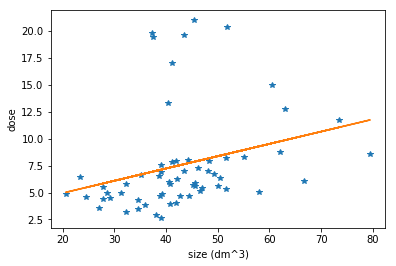

[[0.11423287]] [2.66675503]


In [9]:
reg = LinearRegression().fit(size, dose)

pred_dose = reg.predict(size)
plt.plot(size,dose,'*')
plt.plot(size,pred_dose)
plt.xlabel('size (dm^3)')
plt.ylabel('dose')
plt.show()


print(reg.coef_,reg.intercept_)

So the size has a positive correlation with the dosis used. The regression line is described by $$dose = 0.11423287 \cdot size(dm^3)+ 2.66675503 $$

TODO
- Add function to python file
- Add size without hollow parts,
- Size off differnt organs (bones, fat, etc.)
- function per slice


- image quality, high gradients, maybe gradient at boundary of the body

